# Evaluation Analysis for Recommender Output

In this section we will analyze and compare the generated recommendations and predictions from a predefined list of algorithms with the goal of assessing the performance of each algorithm with respect to a metric. In other words, we would rank the algorithms for each metric considered with respect to performance.

## Setup

Below are the list of packages required to successfully run the analysis. They are divided into partitions to signify their specific task.<br>
We need the pathlib package for working with files and folders

In [1]:
from pathlib import Path
import json

We would use the pandas for analyzing and manipulating our data while seaborn and matplotlib are used for data visualization. statsmodels.graphics.gofplots and scipy.stats.shapiro are used for normality check. Scipy.stats.friedmanchisquare is a non-parametric test used to determine the statistical significance in metric results and the wilcoxon test is used for pairwise comparison of sample data.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations

Import the LensKit metrics for analysis:

In [3]:
from lenskit.data import ItemListCollection, UserIDKey
from lenskit.metrics import RunAnalysis, RMSE, NDCG, RecipRank, RBP

## Load Data

The recommendations are in `runs`, and we will need to reassemble the test data from `test`.

In [4]:
dataset = "ml100k"

In [5]:
# Parameters
dataset = "ml20m"


In [6]:
output_root = Path("runs")

In [7]:
dirs = [fld for fld in output_root.glob(f'{dataset}-*')]

In [8]:
recs = ItemListCollection(['model', 'user_id'], index=False)
for fld in dirs:
    for file in fld.glob("recs-*"):
        rec = pd.read_parquet(file)
        rec = ItemListCollection.from_df(rec, UserIDKey)
        recs.add_from(rec, model=fld.name.split("-")[1])

In [9]:
rec_algos = sorted(set(a for (a, _u) in recs.keys()))
rec_algos

['ALS', 'Bias', 'IALS', 'IIE', 'III', 'Pop', 'UUE']

In [10]:
preds = ItemListCollection(['model', 'user_id'], index=False)
for fld in dirs:
    for file in fld.glob("pred-*"):
        pred = pd.read_parquet(file)
        pred = ItemListCollection.from_df(pred, UserIDKey)
        preds.add_from(pred, model=fld.name.split("-")[1])

We need to load the test data so that we have the ground truths for computing accuracy

In [11]:
split_root = Path("data-split")
split_dir = split_root / dataset

In [12]:
test = ItemListCollection(UserIDKey)
for file in split_dir.glob("test-*.parquet"):
    df = pd.read_parquet(file)
    test.add_from(ItemListCollection.from_df(df, UserIDKey))

## Top-N Metrics

`RunListAnalysis` computes metrics for recommendation results and takes care of
matching recommendations and ground truth.

In [13]:
ra = RunAnalysis()

ra.add_metric(NDCG())
ra.add_metric(RecipRank())
ra.add_metric(RBP())

rec_results = ra.compute(recs, test)
rec_results.list_summary('model')

/home/mde48/lenskit/lkpy/lenskit/lenskit/metrics/bulk.py:116: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


mean        median           std
model                                                    
ALS   NDCG       2.993684e-02  0.000000e+00  6.703253e-02
      RBP        1.227266e-02  0.000000e+00  6.804894e-02
      RecipRank  3.638494e-02  0.000000e+00  1.358151e-01
Bias  NDCG       5.018591e-02  0.000000e+00  9.353811e-02
      RBP        3.322223e-02  0.000000e+00  1.158623e-01
      RecipRank  7.859996e-02  0.000000e+00  2.224595e-01
IALS  NDCG       2.633844e-01  2.168583e-01  1.967490e-01
      RBP        1.183591e-01  1.953363e-03  2.078740e-01
      RecipRank  2.579563e-01  1.111111e-01  3.212040e-01
IIE   NDCG       1.799055e-03  0.000000e+00  1.081409e-02
      RBP        1.657536e-05  0.000000e+00  1.734659e-03
      RecipRank  7.468014e-04  0.000000e+00  6.619561e-03
III   NDCG       2.197107e-01  1.487798e-01  2.105819e-01
      RBP        1.432661e-01  4.882812e-04  2.345441e-01
      RecipRank  2.847712e-01  9.090909e-02  3.673109e-01
Pop   NDCG       1.349406e-01  9.007480e-02  1.482855e-01
      RBP        6.486671e-02  7.465133e-09  1.568487e-01
      RecipRank  1.586887e-01  3.703704e-02  2.766616e-01
UUE   NDCG       1.289179e-04  0.000000e+00  2.515898e-03
      RBP        2.645683e-10  0.000000e+00  5.913135e-08
      RecipRank  4.431305e-05  0.000000e+00  9.301602e-04

We can reshape the list metrics and plot them:

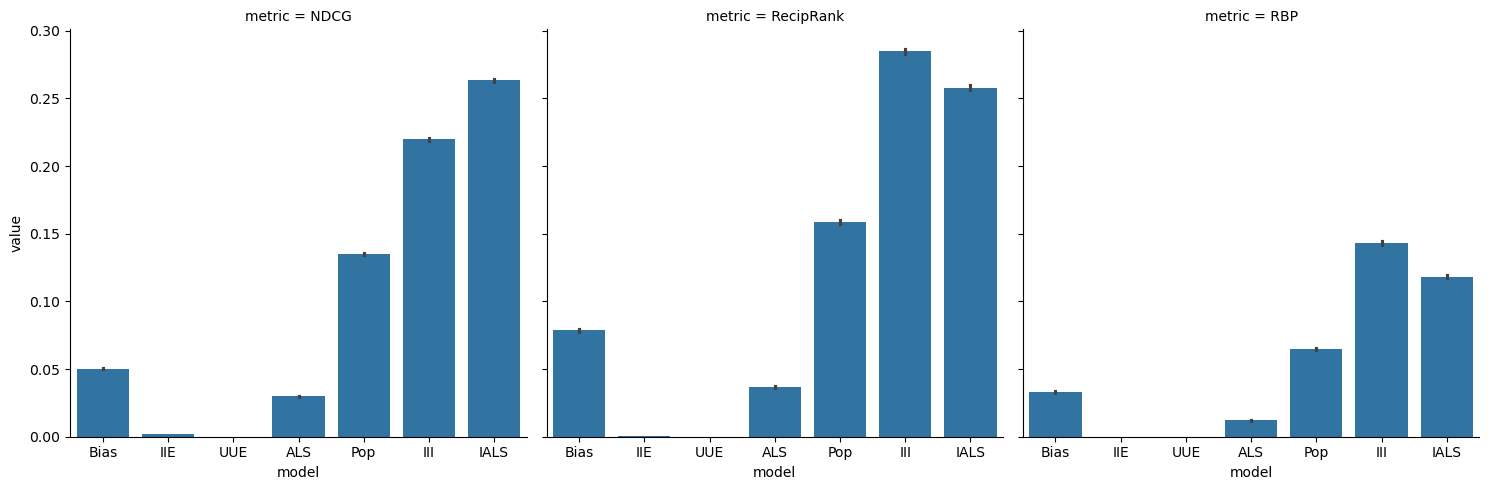

In [14]:
metrics = rec_results.list_metrics()
metrics = metrics.melt(var_name='metric', ignore_index=False).reset_index()
sns.catplot(metrics, x='model', y='value', col='metric', kind='bar')
plt.show()

## Prediction RMSE

We will also look at the prediction RMSE.

In [15]:
pa = RunAnalysis()

pa.add_metric(RMSE(missing_scores='ignore', missing_truth='ignore'))

pred_results = pa.compute(preds, test)
pred_results.list_summary('model')

/home/mde48/lenskit/lkpy/lenskit/lenskit/metrics/bulk.py:116: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


,,mean,median,std
model,,,,
ALS,RMSE,0.785600,0.727572,0.343709
Bias,RMSE,0.829450,0.770576,0.357917
IIE,RMSE,0.771869,0.714103,0.344003
UUE,RMSE,0.798277,0.739411,0.350708


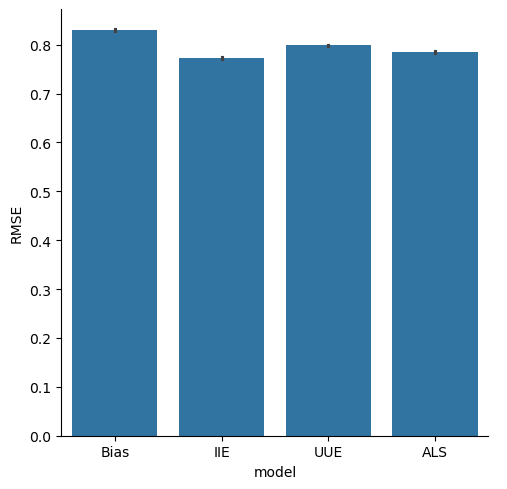

In [16]:
sns.catplot(pred_results.list_metrics().reset_index(), x='model', y='RMSE', kind='bar')
plt.show()

## Save Metrics

We'll now save the metrics to a file.

In [17]:
rlsum = rec_results.list_summary('model')['mean'].unstack()
rlsum

/home/mde48/lenskit/lkpy/lenskit/lenskit/metrics/bulk.py:116: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


,NDCG,RBP,RecipRank
model,,,
ALS,0.029937,1.227266e-02,0.036385
Bias,0.050186,3.322223e-02,0.078600
IALS,0.263384,1.183591e-01,0.257956
IIE,0.001799,1.657536e-05,0.000747
III,0.219711,1.432661e-01,0.284771
Pop,0.134941,6.486671e-02,0.158689
UUE,0.000129,2.645683e-10,0.000044


In [18]:
rlsum.to_json(f'eval-metrics.{dataset}.json', orient='index')